# Compute correlations between flux and abundance - REDS Recall, ATP11C V972M
### Import packages

In [ ]:
import re
import warnings
from collections import defaultdict

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib_venn as mpl_venn
import numpy as np
import pandas as pd
from rbc_gem_utils import (
    COBRA_CONFIGURATION,
    build_string,
    ensure_iterable,
    get_dirpath,
    read_cobra_model,
    show_versions,
)
from rbc_gem_utils.analysis.overlay import (
    DEFAULT_PREFIX_SUFFIX_VALUES,
    DEFAULT_PROTEOME_COMPARTMENT,
    EnzymeDilution,
    add_relaxation_budget,
    classify_reactions_by_abundance_dependence,
    load_overlay_model,
    plot_correlations,
    plot_reaction_counts_for_proteins,
    plot_ring_of_category_counts,
)
from scipy.stats import spearmanr

plt.rcParams["font.family"] = "Arial"

show_versions()


Package Information
-------------------
rbc-gem-utils 0.0.3

Dependency Information
----------------------
beautifulsoup4                       4.13.4
bio                                   1.8.0
cobra                                0.29.1
depinfo                               2.2.0
gurobipy                             12.0.3
matplotlib                           3.10.3
matplotlib-venn                       1.1.2
memote                               0.17.0
networkx                                3.5
notebook                              7.4.4
openpyxl                              3.1.5
pandas                                2.3.1
pre-commit                            4.2.0
rbc-gem-utils[database,network,vis] missing
requests                             2.32.4
scikit-learn                          1.7.0
scipy                                1.16.0
seaborn                              0.13.2

Build Tools Information
-----------------------
pip          25.1
setuptools 78.1.1
wheel      0.45

### Define configuration
#### COBRA Configuration

In [2]:
COBRA_CONFIGURATION.solver = "gurobi"
# Set bound defaults much larger to prevent model loading issues
COBRA_CONFIGURATION.bounds = (-1e-8, 1e8)
COBRA_CONFIGURATION.tolerance = 1e-9
COBRA_CONFIGURATION

Attribute,Description,Value
solver,Mathematical optimization solver,gurobi
tolerance,"General solver tolerance (feasibility, integrality, etc.)",1e-09
lower_bound,Default reaction lower bound,-1e-08
upper_bound,Default reaction upper bound,100000000.0
processes,Number of parallel processes,127
cache_directory,Path for the model cache,C:\Users\P7875\AppData\Local\opencobra\cobrapy\Cache
max_cache_size,Maximum cache size in bytes,104857600
cache_expiration,Model cache expiration time in seconds (if any),None


### Define organism, model, and dataset

In [3]:
organism = "Human"
model_id = "RBC_GEM"
dataset_name = "REDSRecall"
genotype = "ATP11C_V972M"
grouped_data_key = f'{genotype}_Sample'
grouped_data_key

'ATP11C_V972M_Sample'

### Set variables for sample identification

In [4]:
sample_key = "SAMPLE ID"
donor_key = "PUBLIC RECALL DONOR ID"

# For sample IDs
donor_re = re.compile(rf"(?P<donor>S(?P<num>\d\d\d))")
operations = "|".join([x.capitalize() for x in ["mean", "median"]])
operation_re = re.compile(r"(?P<op>" + operations + r")\_(?P<group>\w+)")
sample_id_re = re.compile(
    r"(?!" + operations + r")" + donor_re.pattern + r"\_"
)

### Set computation options

In [5]:
ftype = "xml"  # In our experience, SBML/XML loads faster, but will take up to 4x more space uncompressed as compared to JSON
run_computations = True  # Keep off to use previously computed results
overwrite = False  # Whether to allow overwriting of previous simulation results
verbose = True

# Objective reactions
objective_reactions = ["NaKt"] 
# Reactions that must have the capability to carry flux, sort for consistency
required_flux_reactions = ["PSFLIPt"] # Add reactions to this list
required_flux_reactions = sorted(set(objective_reactions + required_flux_reactions))


generate_all_group_visuals = False

#### Set prefixes/suffixes to expect

In [6]:
enzyme_rxn_prefix = DEFAULT_PREFIX_SUFFIX_VALUES["enzymes"]["prefix.dilution"]
enzyme_met_prefix = DEFAULT_PREFIX_SUFFIX_VALUES["enzymes"]["prefix.metabolite"]
enzyme_met_suffix_total = DEFAULT_PREFIX_SUFFIX_VALUES["enzymes"]["suffix.total"]
comp_suffix = f"_{DEFAULT_PROTEOME_COMPARTMENT}"

### Set figure options

In [7]:
save_figures = True
transparent = False
imagetype = "svg"

### Set paths

In [8]:
# Set paths
processed_data_dirpath = get_dirpath(use_temp="processed") / organism / dataset_name
# Set paths
overlay_dirpath = get_dirpath("analysis") / "OVERLAY" / organism
model_dirpath = overlay_dirpath / model_id
results_dirpath = (get_dirpath(use_temp="processed") / model_id / "OVERLAY" / organism / dataset_name / grouped_data_key)
pcfva_results_dirpath = (results_dirpath / "pcFVA" / "_".join(("REQ", *required_flux_reactions)) /  "_".join(("OBJ", *objective_reactions)))
# Objective reaction does not matter since correlations are computed
# based on min and max fluxes and abundance, which are obtained when optimum is 0.
corr_results_dirpath = results_dirpath / "correlations"
# Ensure directory  exists
corr_results_dirpath.mkdir(exist_ok=True, parents=True)

## Load RBC-GEM model

In [9]:
model = read_cobra_model(filename=model_dirpath / f"{model_id}.xml")
pcmodel = load_overlay_model(filename=model_dirpath / f"{model_id}_PC.xml")

# Add relaxation budget to initial PC model to get names of relaxation reactions
add_relaxation_budget(pcmodel, 0, verbose=False)
pcmodel

Set parameter Username
Set parameter LicenseID to value 2664191
Academic license - for non-commercial use only - expires 2026-05-12


Name,RBC_GEM_PC
Memory address,25bcc751fd0
Number of metabolites,7815
Number of reactions,15687
Number of genes,723
Number of groups,68
Objective expression,1.0*NaKt - 1.0*NaKt_reverse_db47e
Compartments,"cytosol, extracellular space, protein compartment"


## Load pcFVA generated results

In [10]:
# Load DataFrame of generated results
df_pcfva_all = pd.read_csv(
    pcfva_results_dirpath / f"{pcmodel.id}_All_FVAsols.zip",
    index_col=None,
).fillna(0)

df_pcfva_all

,reactions,model,optimum,min,max
0,1SGTH2OHE1ABCte,RBC_GEM_PC_Allele0_C0,0.0,0.000000,0.014662
1,1SGTH2OHE1ABCte,RBC_GEM_PC_Allele0_C1,0.0,0.000000,0.015382
2,1SGTH2OHE1ABCte,RBC_GEM_PC_Allele0_C10,0.0,0.000000,0.014452
3,1SGTH2OHE1ABCte,RBC_GEM_PC_Allele0_C11,0.0,0.000000,0.013871
4,1SGTH2OHE1ABCte,RBC_GEM_PC_Allele0_C12,0.0,0.000000,0.011371
...,...,...,...,...,...
122849,XYLU_Dt,RBC_GEM_PC_Mean_Allele1,0.0,-0.040632,0.040163
122850,XYLU_Dt,RBC_GEM_PC_Mean_Allele2,0.0,-0.053639,0.052341
122851,XYLU_Dt,RBC_GEM_PC_Median_Allele0,0.0,-0.037719,0.036706
122852,XYLU_Dt,RBC_GEM_PC_Median_Allele1,0.0,-0.040235,0.039949


## Create DataFrame for calculations and visualizations
### Get maximum reaction fluxes and associated abundance values
#### Get maximum reaction fluxes and ranges

In [11]:
rxns = model.reactions.query(lambda x: len(x.genes)).list_attr("id")
df_max_flux_per_model = df_pcfva_all[df_pcfva_all["reactions"].isin(rxns)].copy()
df_max_flux_per_model = df_max_flux_per_model.groupby(
    ["model", "reactions", "optimum"]
)[["min", "max"]].agg(
    {
        "min": "min",  # Minimum reaction flux per model
        "max": "max",  # Maximum reaction flux per model
    }
)
# Address issues possibly caused by floating point precision, ideally a value that prevents any negative ranges
df_max_flux_per_model.loc[df_max_flux_per_model["max"] < df_max_flux_per_model["min"], ["max", "min"]] = [0, 0]
atol = COBRA_CONFIGURATION.tolerance
df_max_flux_per_model["max"] = df_max_flux_per_model["max"].apply(lambda x: 0 if np.isclose(x, 0, atol=atol) else round(x, -int(np.log10(atol))))
df_max_flux_per_model["min"] = df_max_flux_per_model["min"].apply(lambda x: 0 if np.isclose(x, 0, atol=atol) else round(x, -int(np.log10(atol))))
df_max_flux_per_model = pd.concat(
    (
        df_max_flux_per_model.abs().max(axis=1),  # Max flux
        df_max_flux_per_model["max"] - df_max_flux_per_model["min"],  # Max range
    ),
    axis=1,
)
df_max_flux_per_model.columns = ["flux", "range"]
# Ensure no negative values, if results appear then tolerance should be adjusted
df_max_flux_per_model[df_max_flux_per_model["range"] < 0]

,,,flux,range
model,reactions,optimum,,


#### Get maximum "enzyme" abundances

In [12]:
rxns = pcmodel.reactions.query(lambda x: isinstance(x, EnzymeDilution) and x.id.endswith(f"{enzyme_met_suffix_total}{comp_suffix}")).list_attr("id")
df_max_abundance_per_model = df_pcfva_all[df_pcfva_all["reactions"].isin(rxns)].copy()
# Rename dilution reactions to match
reaction_enzyme_map = {
    enzyme_rid: enzyme_rid.replace(
        f"{enzyme_rxn_prefix}{enzyme_met_prefix}", ""
    ).replace(f"{enzyme_met_suffix_total}{comp_suffix}", "")
    for enzyme_rid in df_max_abundance_per_model["reactions"]
}
df_max_abundance_per_model["reactions"] = df_max_abundance_per_model["reactions"].replace(reaction_enzyme_map)
df_max_abundance_per_model = df_max_abundance_per_model.groupby(["model", "reactions", "optimum"])[["max"]].max()
# Address issues possibly caused by floating point precision, atol is ideally a value that prevents any negative ranges
atol = COBRA_CONFIGURATION.tolerance
df_max_abundance_per_model["max"] = df_max_abundance_per_model["max"].apply(lambda x: 0 if x < 0 else x)
df_max_abundance_per_model["max"] = df_max_abundance_per_model["max"].apply(lambda x: 0 if np.isclose(x, 0, atol=atol) else round(x, -int(np.log10(atol))))
df_max_abundance_per_model = df_max_abundance_per_model.rename({"max": "abundance"}, axis=1)
# Ensure no negative values, if results appear then tolerance should be adjusted
df_max_abundance_per_model[(df_max_abundance_per_model < 0).any(axis=1)]

,,,abundance
model,reactions,optimum,


#### Merge DataFrames

In [13]:
df_data_all = pd.merge(
    df_max_flux_per_model,
    df_max_abundance_per_model,
    left_index=True,
    right_index=True,
    how="left",
)
df_data_all = df_data_all.reset_index(drop=False)
df_data_all

,model,reactions,optimum,flux,range,abundance
0,RBC_GEM_PC_Allele0_C0,1SGTH2OHE1ABCte,0.0,0.014662,0.014662,0.062658
1,RBC_GEM_PC_Allele0_C0,1SGTH2OHE2ABCte,0.0,0.014662,0.014662,0.062658
2,RBC_GEM_PC_Allele0_C0,23E1QN1GST,0.0,0.014662,0.014662,21.624986
3,RBC_GEM_PC_Allele0_C0,23E1QN4GST,0.0,0.014662,0.014662,21.624986
4,RBC_GEM_PC_Allele0_C0,23E2QN1GST,0.0,0.014662,0.014662,21.624986
...,...,...,...,...,...,...
34271,RBC_GEM_PC_Median_Allele2,URIt,0.0,0.081527,0.081527,1.697647
34272,RBC_GEM_PC_Median_Allele2,VATPASEte,0.0,0.000003,0.000003,0.000012
34273,RBC_GEM_PC_Median_Allele2,XPPT,0.0,0.001255,0.001255,1.135774
34274,RBC_GEM_PC_Median_Allele2,XYLK,0.0,0.000000,0.000000,0.000000


### Identify genotypes for results

In [14]:
df_data_all["sample"] = df_data_all["model"].apply(lambda x: x.replace(f"{pcmodel.id}_", ""))
df_data_all[genotype] = df_data_all["sample"].apply(lambda x: x.split("_", 1)[0].replace("Allele", ""))
df_data_all

,model,reactions,optimum,flux,range,abundance,sample,ATP11C_V972M
0,RBC_GEM_PC_Allele0_C0,1SGTH2OHE1ABCte,0.0,0.014662,0.014662,0.062658,Allele0_C0,0
1,RBC_GEM_PC_Allele0_C0,1SGTH2OHE2ABCte,0.0,0.014662,0.014662,0.062658,Allele0_C0,0
2,RBC_GEM_PC_Allele0_C0,23E1QN1GST,0.0,0.014662,0.014662,21.624986,Allele0_C0,0
3,RBC_GEM_PC_Allele0_C0,23E1QN4GST,0.0,0.014662,0.014662,21.624986,Allele0_C0,0
4,RBC_GEM_PC_Allele0_C0,23E2QN1GST,0.0,0.014662,0.014662,21.624986,Allele0_C0,0
...,...,...,...,...,...,...,...,...
34271,RBC_GEM_PC_Median_Allele2,URIt,0.0,0.081527,0.081527,1.697647,Median_Allele2,Median
34272,RBC_GEM_PC_Median_Allele2,VATPASEte,0.0,0.000003,0.000003,0.000012,Median_Allele2,Median
34273,RBC_GEM_PC_Median_Allele2,XPPT,0.0,0.001255,0.001255,1.135774,Median_Allele2,Median
34274,RBC_GEM_PC_Median_Allele2,XYLK,0.0,0.000000,0.000000,0.000000,Median_Allele2,Median


## Compute correlations between flux and abundance for samples
### Remove models based on data operations

In [15]:
df_data_for_analyses = df_data_all[[not bool(operation_re.search(x)) for x in df_data_all["model"]]].reset_index(drop=True)
df_data_for_analyses

,model,reactions,optimum,flux,range,abundance,sample,ATP11C_V972M
0,RBC_GEM_PC_Allele0_C0,1SGTH2OHE1ABCte,0.0,0.014662,0.014662,0.062658,Allele0_C0,0
1,RBC_GEM_PC_Allele0_C0,1SGTH2OHE2ABCte,0.0,0.014662,0.014662,0.062658,Allele0_C0,0
2,RBC_GEM_PC_Allele0_C0,23E1QN1GST,0.0,0.014662,0.014662,21.624986,Allele0_C0,0
3,RBC_GEM_PC_Allele0_C0,23E1QN4GST,0.0,0.014662,0.014662,21.624986,Allele0_C0,0
4,RBC_GEM_PC_Allele0_C0,23E2QN1GST,0.0,0.014662,0.014662,21.624986,Allele0_C0,0
...,...,...,...,...,...,...,...,...
28859,RBC_GEM_PC_Allele2_S417_D42,URIt,0.0,0.076089,0.076089,1.587484,Allele2_S417_D42,2
28860,RBC_GEM_PC_Allele2_S417_D42,VATPASEte,0.0,0.000003,0.000003,0.000012,Allele2_S417_D42,2
28861,RBC_GEM_PC_Allele2_S417_D42,XPPT,0.0,0.000714,0.000714,1.187846,Allele2_S417_D42,2
28862,RBC_GEM_PC_Allele2_S417_D42,XYLK,0.0,0.006054,0.006054,0.025872,Allele2_S417_D42,2


### Create groups of sample models

In [16]:
spearman_correlations_dict = defaultdict(dict)

all_key = grouped_data_key
id_key = "sample"
model_groups = {all_key: list(df_data_for_analyses[id_key].unique())}

def create_group_of_models(df, id_key, groupby, verbose=False):
    grouped = df.groupby(groupby)[id_key].agg(lambda x: list(x.unique()))
    grouped = {"_".join([str(x) for x in ensure_iterable(k)]): v for k, v in grouped.to_dict().items()}
    if verbose:
        max_name_len = max([len(group_name) for group_name in list(grouped)])
        for group_name, model_list in grouped.items():
            spacepad = "".join([" "] * (max_name_len - len(group_name)))
            print(f"{group_name}:{spacepad}\t{len(model_list)} samples")
    return grouped

### View model groups

In [17]:
print("Possible groups for analyses\n============================")
max_name_len = max([len(group_name) for group_name in list(model_groups)])
for group_name, model_list in model_groups.items():
    spacepad = "".join([" "] * (max_name_len - len(group_name)))
    print(f"{group_name}:{spacepad}\t{len(model_list)} samples")

df_data_for_analyses = df_data_for_analyses.set_index(["reactions", id_key])
df_data_for_analyses

Possible groups for analyses
ATP11C_V972M_Sample:	32 samples


,,model,optimum,flux,range,abundance,ATP11C_V972M
reactions,sample,,,,,,
1SGTH2OHE1ABCte,Allele0_C0,RBC_GEM_PC_Allele0_C0,0.0,0.014662,0.014662,0.062658,0
1SGTH2OHE2ABCte,Allele0_C0,RBC_GEM_PC_Allele0_C0,0.0,0.014662,0.014662,0.062658,0
23E1QN1GST,Allele0_C0,RBC_GEM_PC_Allele0_C0,0.0,0.014662,0.014662,21.624986,0
23E1QN4GST,Allele0_C0,RBC_GEM_PC_Allele0_C0,0.0,0.014662,0.014662,21.624986,0
23E2QN1GST,Allele0_C0,RBC_GEM_PC_Allele0_C0,0.0,0.014662,0.014662,21.624986,0
...,...,...,...,...,...,...,...
URIt,Allele2_S417_D42,RBC_GEM_PC_Allele2_S417_D42,0.0,0.076089,0.076089,1.587484,2
VATPASEte,Allele2_S417_D42,RBC_GEM_PC_Allele2_S417_D42,0.0,0.000003,0.000003,0.000012,2
XPPT,Allele2_S417_D42,RBC_GEM_PC_Allele2_S417_D42,0.0,0.000714,0.000714,1.187846,2


### Ensure groups exist and setup directory structure

In [18]:
group_results_dirpath_dict = {all_key: corr_results_dirpath}
header = "Expected directory structure"
print("\n".join((header, "=" * len(header), all_key)))
print(u"\u2514\u2500\u2500" + f" {group_results_dirpath_dict[all_key].name}")

Expected directory structure
ATP11C_V972M_Sample
└── correlations


### Compute spearman rank coefficients and p-values
#### Compute correlations for each provided group

In [19]:
# Leave empty to use all groups, otherwise pnly calculate correlations for provided group
group_names = {}
correlations_pairs = [("flux", "abundance")]
for idx, (group_name, group_results_dirpath) in enumerate(
    group_results_dirpath_dict.items(), start=1
):
    if group_names and group_name not in group_names:
        continue
    group_results_dirpath.mkdir(exist_ok=True, parents=True)
    model_list = model_groups[group_name]
    if verbose:
        header = "{}) Computing correlations between for group '{}'".format(
            idx, group_name
        )
        print("\n".join(("=" * len(header), header, "=" * len(header))))
    for correlations_pair in correlations_pairs:
        filepath = (
            group_results_dirpath / f"{correlations_pair[0]}_{correlations_pair[1]}.tsv"
        )
        if run_computations:
            if filepath.exists() and not overwrite:
                if verbose:
                    print(
                        "Already computed correlations between '{}' and '{}'".format(
                            *correlations_pair
                        )
                    )
                df_correlations = pd.read_csv(filepath, sep="\t", index_col=0)
            else:
                correlations_dict = defaultdict(dict)
                for reaction in df_data_for_analyses.index.unique(level="reactions"):
                    # Extract out values corresponding to the reaction and model list
                    df_rxn_per_samples = df_data_for_analyses.loc[
                        reaction, list(correlations_pair)
                    ].loc[model_list]
                    with warnings.catch_warnings(action="ignore"):
                        rho, pvalue = spearmanr(df_rxn_per_samples)
                    correlations_dict[reaction].update({"rho": rho, "p-value": pvalue})
                    if int(verbose) > 1:
                        print(f"For reaction {reaction}:rho={rho:.4f}, p={pvalue:.4e}")
                df_correlations = pd.DataFrame.from_dict(
                    correlations_dict, orient="index"
                )
                df_correlations.index.name = "reactions"
                df_correlations.to_csv(filepath, sep="\t", index=True)
                if verbose:
                    print(
                        "Finished computing correlations between '{}' and '{}'".format(
                            *correlations_pair
                        )
                    )
        else:
            try:
                df_correlations = pd.read_csv(filepath, sep="\t", index_col=0)
            except FileNotFoundError:
                df_correlations = pd.DataFrame(
                    [], index=df_data_for_analyses.index.unique(level="reactions")
                )
                print(
                    "No previously computed correlations between '{}' and '{}'".format(
                        *correlations_pair
                    )
                )
            else:
                print(
                    "Already computed correlationsbetween '{}' and '{}'".format(
                        *correlations_pair
                    )
                )

        spearman_correlations_dict[group_name][correlations_pair] = df_correlations
    print()

1) Computing correlations between for group 'ATP11C_V972M_Sample'
Finished computing correlations between 'flux' and 'abundance'



### Classify reactions based on correlation values for all groups
Generate figure results for every group. Results can be overriden with by exploring individual groups and changing options for each individually.
#### Load subsystems and metabolic categories to enrich results

In [20]:
subsystems_to_exclude = {"Pseudoreactions"}
use_abbrevs = True
abbreviations = {
    "Amino acid metabolism": "A",
    "Carbohydrate metabolism": "C",
    "Lipid metabolism": "L",
    "Metabolism of cofactors and vitamins": "V",
    "Nucleotide metabolism": "N",
    "Reactive species": "R",
    "Transport reactions": "T",
    "Other": "O",
}
categories_to_keep = list(abbreviations)

df_pathways = pd.read_csv(
    get_dirpath("curation") / "subsystems.tsv", sep="\t", dtype=str
).fillna("")

# Rename "name" to subsystem to match reaction attribute
df_pathways = df_pathways.rename({"name": "subsystem"}, axis=1)
# Group "Metabolism of other amino acids" with amino acids rather than treat as "other"
df_pathways["category"] = df_pathways["category"].replace(
    "Metabolism of other amino acids", "Amino acid metabolism"
)

df_pathways["category"] = df_pathways["category"].apply(
    lambda x: ("Other" if x not in categories_to_keep else x)
)
df_pathways = df_pathways[~df_pathways["subsystem"].isin(subsystems_to_exclude)].copy()
df_pathways

,subsystem,category,kegg.pathway.name,kegg.pathway,notes
0,"Alanine, aspartate and glutamate metabolism",Amino acid metabolism,"Alanine, aspartate and glutamate metabolism",hsa00250,
1,Arginine and proline metabolism,Amino acid metabolism,Arginine and proline metabolism,hsa00330,
2,Cysteine and methionine metabolism,Amino acid metabolism,Cysteine and methionine metabolism,hsa00270,
3,"Glycine, serine and threonine metabolism",Amino acid metabolism,"Glycine, serine and threonine metabolism",hsa00260,
4,Histidine metabolism,Amino acid metabolism,Histidine metabolism,hsa00340,
...,...,...,...,...,...
73,Aminoacyl-tRNA biosynthesis,Other,Aminoacyl-tRNA biosynthesis,has00970,
74,"Transport, extracellular",Transport reactions,,,Representative subsystem for all transport rea...
75,5-fluorouracil metabolism,Other,Drug metabolism - other enzymes,hsa00983,"Subnetwork of KEGG pathway ""Drug metabolism - ..."
76,Azathioprine and 6-mercaptopurine metabolism,Other,Drug metabolism - other enzymes,hsa00983,"Subnetwork of KEGG pathway ""Drug metabolism - ..."


#### Set visualization options to be applied to all plots

In [21]:
abundance_dependent_cutoff = 0.8
abundance_correlated_cutoff = 0.5

lower_abundance_labels = (
    True  # Whether abundance labels should be at the top or bottom of the plot
)
plot_correlation_kwargs = dict(
    scatter_inch=5,  # Length x width of scatter plot
    hist_inch=1,  # Length or width of histogram addition
    hist_pad=0.4,  # Space between scatter and histogram
    cmap="viridis",  # Colormap for correlation significance
    edgecolor="black",
    edgewidth=0.5,
    grid=False,
    zorder=2,
    colorbar=True,
    xmin=-1,
    xmax=1,
    xpad=0.05,
    xtick_major=0.4,
    ytick_major=45,
    xhist=True,  # Whehter to include a histogram of the x-axis values (rho)
    yhist=True,  # Whether to include a histogram of the y-axis values (log10(-p))
    xhist_ytick_major=100,  # Major y-tick interval for histogram aligned with x-axis
    yhist_xtick_major=600,  # Major x-tick interval for histogram aligned with y-axis
)
plot_correlation_kwargs.update(
    dict(
        xtick_minor=(
            plot_correlation_kwargs.get("xtick_major") / 4
            if plot_correlation_kwargs.get("xtick_major")
            else None
        ),
        xhist_ytick_minor=(
            plot_correlation_kwargs.get("xhist_ytick_major") / 2
            if plot_correlation_kwargs.get("xhist_ytick_major")
            else None
        ),  # Major y-tick interval for histogram aligned with x`-axis
        ytick_minor=(
            plot_correlation_kwargs.get("ytick_major") / 5
            if plot_correlation_kwargs.get("ytick_major")
            else None
        ),
        yhist_xtick_minor=(
            plot_correlation_kwargs.get("yhist_xtick_major") / 2
            if plot_correlation_kwargs.get("yhist_xtick_major")
            else None
        ),  # Major y-tick interval for histogram aligned with x`-axis
    )
)
# plot_correlation_kwargs.update(
#     dict(
#         xbinwidth=plot_correlation_kwargs.get("xtick_minor")/2 if plot_correlation_kwargs.get("xtick_minor") else None, # Determined by minor ticks if not otherwise set
#         ybinwidth=plot_correlation_kwargs.get("ytick_minor")/2 if plot_correlation_kwargs.get("ytick_minor") else None, # Determined by minor ticks if not otherwise set
#     )
# )
# Vertical lines need in a dict where keys are values for the line,
# and values are given as (dict of line properties, dict of text properties)
lineprops = dict(linewidth=2)
textprops = dict(
    rotation=90,
    fontsize="large",
    va="center",
    ha="left",
)
# Set common line properties
labels = ["Dependent", "Correlated", "Independent"]
cutoff_values = [
    abundance_dependent_cutoff,
    abundance_correlated_cutoff,
    plot_correlation_kwargs["xmin"],
]
vertical_lines = {
    value: (lineprops.copy(), textprops.copy()) for value in cutoff_values
}
# Set individual line properties
colors = dict(zip(cutoff_values, ["black", "black", "white"]))
linestyles = dict(zip(cutoff_values, ["-", "--", ""]))
for key, label in zip(cutoff_values, labels):
    vertical_lines[key][0].update({"color": colors[key], "linestyle": linestyles[key]})
    vertical_lines[key][1].update({"s": label})

ring_figsize = 3.6
plot_ring_kwargs = dict(
    wedgesize=0.43,
    radius=1,
    linewidth=0.75,
    edgecolor="k",
    inner_label_dist=2,
    outer_label_dist=None,
    barsize=0.8,
    cmax=0.8,
    cmin=0.15,
    ring_center_textprops=dict(ha="center", va="center", fontsize="medium"),
)
category_cmaps = {
    "Amino acid metabolism": "spring",
    "Carbohydrate metabolism": "Greens",
    "Lipid metabolism": "Blues",
    "Metabolism of cofactors and vitamins": "summer",
    "Nucleotide metabolism": "winter",
    "Reactive species": "Reds",
    "Transport reactions": "Purples",
    "Other": "Grays",
}

plot_reaction_counts_kwargs = dict(
    height=0.8, cmax=0.85, ticklabels_on_bars=True, xtick_major=10, xtick_minor=5
)

#### Generate all figures
Comment this cell out to prevent generation of all figures

In [22]:
for idx, group_name in enumerate(list(spearman_correlations_dict), start=1):
    group_results_dirpath = group_results_dirpath_dict[group_name]
    print(f"{idx}) Generating figures for group '{group_name}'")
    nrows, ncols = (1, 1)
    correlation_pair = ("flux", "abundance")
    fig = mpl.figure.Figure(
        figsize=(
            plot_correlation_kwargs["scatter_inch"]
            + (
                (
                    plot_correlation_kwargs["hist_inch"]
                    + plot_correlation_kwargs["hist_pad"]
                )
                if plot_correlation_kwargs["yhist"]
                else 0
            )
            * ncols,
            plot_correlation_kwargs["scatter_inch"]
            + (
                (
                    plot_correlation_kwargs["hist_inch"]
                    + plot_correlation_kwargs["hist_pad"]
                )
                if plot_correlation_kwargs["xhist"]
                else 0
            )
            * nrows,
        )
    )
    ax = fig.subplots(
        nrows=nrows,
        ncols=ncols,
    )

    df_correlations = spearman_correlations_dict[group_name][correlation_pair]
    log_pvalue_sub_for_inf = np.floor(
        np.log10(df_correlations[df_correlations["p-value"] != 0]["p-value"].min()) - 1
    )

    # Vertical lines textprops are dependent on value in loop
    for key in list(vertical_lines):
        vertical_lines[key][1].update(
            {"y": -log_pvalue_sub_for_inf * (0.15 if lower_abundance_labels else 0.85)}
        )

    # Remove all NA values and transform p-values to log10(-p)values
    df_corr = df_correlations.dropna(axis=0).copy()
    df_corr["p-value"] = (
        -df_corr["p-value"]
        .apply(np.log10)
        .replace(-float("inf"), log_pvalue_sub_for_inf)
    )
    df_corr = df_corr.sort_values(by=list(df_corr.columns), ascending=False)

    ax_scatter, ax_xhist, ax_yhist = plot_correlations(
        df_corr,
        ax=ax,
        vertical_lines=vertical_lines,
        **plot_correlation_kwargs,
    )

    ax_scatter.set_title(
        "Correlates between {} and {}".format(
            *[x.capitalize() for x in correlations_pair]
        ),
        fontsize="large",
    )

    if save_figures:
        fig.savefig(
            group_results_dirpath / f"FluxAbunCorrelates_{model.id}.{imagetype}",
            transparent=transparent,
            format=imagetype,
        )

    df_classified_reactions = classify_reactions_by_abundance_dependence(
        df_correlations,
        dependent_cutoff=abundance_dependent_cutoff,
        correlated_cutoff=abundance_correlated_cutoff,
        spontaneous_reactions=[
            r.id
            for r in model.reactions.query(lambda x: not x.boundary and not x.genes)
        ],
    )
    # Concat original correlation values to classificaiton Series
    df_classified_reactions = pd.concat(
        (df_classified_reactions, df_correlations), axis=1
    )
    df_classified_reactions_categories = pd.concat(
        (
            df_classified_reactions,
            pd.Series(
                {
                    r.id: r.subsystem
                    for r in model.reactions.get_by_any(
                        list(df_classified_reactions.index)
                    )
                }
            ),
        ),
        axis=1,
    )
    df_classified_reactions_categories = df_classified_reactions_categories.reset_index(
        drop=False
    )
    df_classified_reactions_categories.columns = (
        ["reactions"] + list(df_classified_reactions.columns) + ["subsystem"]
    )
    df_classified_reactions_categories = df_classified_reactions_categories.merge(
        df_pathways[["subsystem", "category"]],
        left_on="subsystem",
        right_on="subsystem",
        how="left",
    )
    df_classified_reactions_categories["genes"] = df_classified_reactions_categories[
        "reactions"
    ].apply(
        lambda x: build_string(
            sorted([g.id for g in model.reactions.get_by_id(x).genes])
        )
    )
    df_classified_reactions_categories.to_csv(
        group_results_dirpath / f"ClassifiedReactionsTable_{model.id}.tsv",
        sep="\t",
        index=False,
    )

    classifications_w_texts = {
        "independent": rf"$\rho  <{abundance_correlated_cutoff}$",
        "correlated": rf"${abundance_correlated_cutoff} \leq \rho < {abundance_dependent_cutoff}$",
        "dependent": rf"${abundance_dependent_cutoff} \leq \rho$",
    }

    all_rings_fig = mpl.figure.Figure(
        figsize=(ring_figsize * len(classifications_w_texts), ring_figsize)
    )
    all_rings_axes = all_rings_fig.subplots(1, len(classifications_w_texts))
    for idx, (classification, ring_center_text) in enumerate(
        classifications_w_texts.items()
    ):
        df = df_classified_reactions_categories[
            df_classified_reactions_categories["classification"] == classification
        ]
        fig_ring = mpl.figure.Figure(figsize=(ring_figsize, ring_figsize))
        ax_ring = fig_ring.add_subplot()
        ax_ring = plot_ring_of_category_counts(
            df.loc[:, ["category", "subsystem"]].copy(),
            ax=ax_ring,
            ring_center_text="\n".join((ring_center_text, f"{len(df)} reactions")),
            cmap_dict_level_0=category_cmaps,
        )
        fig_ring.tight_layout()
        if save_figures:
            fig_ring.savefig(
                group_results_dirpath
                / f"{classification.capitalize()}Reactions_{model_id}.{imagetype}",
                transparent=transparent,
                format=imagetype,
            )
        fig_bar = mpl.figure.Figure(figsize=(5, 10))
        ax_bar = fig_bar.add_subplot()
        plot_reaction_counts_for_proteins(
            df,
            ax=ax_bar,
            cutoff_value=5,
            seperator_value=20,
            seperator_scalar=5,
            category_colors=category_cmaps,
            **plot_reaction_counts_kwargs,
        )
        if save_figures:
            fig_bar.savefig(
                group_results_dirpath
                / f"{classification.capitalize()}ProtRxnCounts_{model_id}.{imagetype}",
                transparent=transparent,
                format=imagetype,
            )
        plot_ring_of_category_counts(
            df.loc[:, ["category", "subsystem"]].copy(),
            ax=all_rings_axes[idx],
            ring_center_text="\n".join((ring_center_text, f"{len(df)} reactions")),
            cmap_dict_level_0=category_cmaps,
        )
    all_rings_fig.tight_layout()
    if save_figures:
        all_rings_fig.savefig(
            group_results_dirpath / f"AllClassifiedReactions_{model_id}.{imagetype}",
            transparent=transparent,
            format=imagetype,
        )

    df_venn = df_classified_reactions_categories.copy()
    df_venn["genes"] = df_venn["genes"].str.split(";")
    df_venn = df_venn[["classification", "genes"]].explode("genes")
    df_venn = (
        df_venn[df_venn != ""]
        .groupby(["classification"])
        .agg(lambda x: list(set(x.unique())))
    )

    fig_venn = mpl.figure.Figure(figsize=(4, 4))
    ax_venn = fig_venn.add_subplot()
    subsets = [
        set(df_venn.loc["dependent"].item()),
        set(df_venn.loc["correlated"].item()),
        set(df_venn.loc["independent"].item()),
    ]
    venn = mpl_venn.venn3(
        subsets=subsets,
        set_labels=[
            "Abundance\ndependent",
            "Abundance\ncorrelated",
            "Abundance\nindependent",
        ],
        set_colors=("xkcd:red", "xkcd:blue", "xkcd:green"),
        alpha=0.5,
        ax=ax_venn,
    )
    circles = mpl_venn.venn3_circles(
        ax=ax_venn, subsets=subsets, linestyle="-", color="black", linewidth=1
    )
    for text in venn.set_labels:
        text.set_fontsize("x-large")
    for text in venn.subset_labels:
        text.set_fontsize("x-large")

    fig_venn.tight_layout()
    if save_figures:
        fig_venn.savefig(
            group_results_dirpath / f"ProteinIntersections_{model_id}.{imagetype}",
            transparent=transparent,
            format=imagetype,
        )

1) Generating figures for group 'ATP11C_V972M_Sample'


### Classify reactions based on correlation values for one group

In [23]:
abundance_dependent_cutoff = 0.8
abundance_correlated_cutoff = 0.5

group_name = all_key
if group_name not in spearman_correlations_dict:
    raise KeyError(f"No previously computed correlations found for group {group_name}")
df_correlations = spearman_correlations_dict[group_name][("flux", "abundance")]
group_results_dirpath = group_results_dirpath_dict[group_name]
log_pvalue_sub_for_inf = np.floor(
    np.log10(df_correlations[df_correlations["p-value"] != 0]["p-value"].min()) - 1
)

#### Summarize classification results for one group

In [24]:
df_classified_reactions = classify_reactions_by_abundance_dependence(
    df_correlations,
    dependent_cutoff=abundance_dependent_cutoff,
    correlated_cutoff=abundance_correlated_cutoff,
    spontaneous_reactions=[
        r.id for r in model.reactions.query(lambda x: not x.boundary and not x.genes)
    ],
)
# Concat original correlation values to classificaiton Series
df_classified_reactions = pd.concat((df_classified_reactions, df_correlations), axis=1)

labels = ["independent", "correlated", "dependent"]
for key, value in (
    df_classified_reactions["classification"]
    .value_counts()[["spontaneous", "blocked"] + labels]
    .items()
):
    if key in labels:
        key = f"abundance-{key}"
    print(f"Number of {key} reactions: {value}")

df_most_significant = df_classified_reactions.dropna(subset=["p-value"])
df_most_significant = (
    -df_most_significant["p-value"]
    .apply(np.log10)
    .replace(-float("inf"), log_pvalue_sub_for_inf)
)
df_most_significant = df_most_significant[
    df_most_significant >= -log_pvalue_sub_for_inf * 0.9
]
print(f"Number of reactions >= 90% max pvalue: {df_most_significant.index.nunique()}")

Number of spontaneous reactions: 468
Number of blocked reactions: 7
Number of abundance-independent reactions: 389
Number of abundance-correlated reactions: 79
Number of abundance-dependent reactions: 427
Number of reactions >= 90% max pvalue: 282


#### Visualize correlations for one group
##### Set visualization options

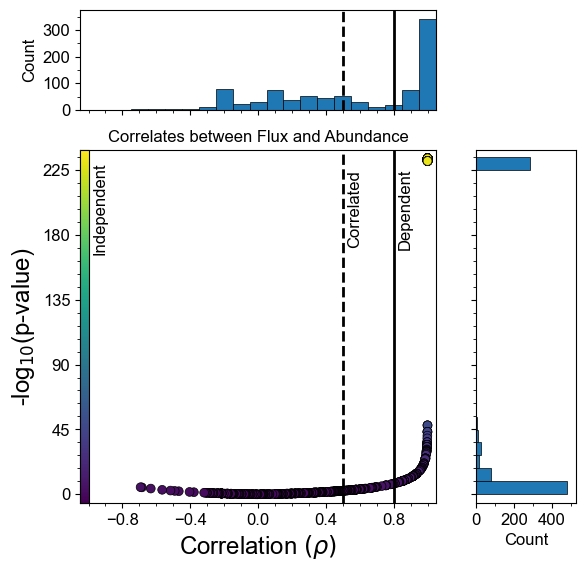

In [25]:
lower_abundance_labels = (
    False  # Whether abundance labels should be at the top or bottom of the plot
)
# Start with previous settings, then modify as desired
plot_kwargs = plot_correlation_kwargs.copy()
plot_kwargs.update(
    scatter_inch=5,  # Length x width of scatter plot
    hist_inch=1,  # Length or width of histogram addition
    hist_pad=0.4,  # Space between scatter and histogram
    cmap="viridis",  # Colormap for correlation significance
    edgecolor="black",
    edgewidth=0.5,
    grid=False,
    zorder=2,
    colorbar=True,
    xmin=-1,
    xmax=1,
    xpad=0.05,
    xtick_major=0.4,
    ytick_major=45,
    xhist=True,  # Whehter to include a histogram of the x-axis values (rho)
    yhist=True,  # Whether to include a histogram of the y-axis values (log10(-p))
    xhist_ytick_major=100,  # Major y-tick interval for histogram aligned with x-axis
    yhist_xtick_major=200,  # Major x-tick interval for histogram aligned with y-axis
)
plot_kwargs.update(
    dict(
        xtick_minor=(
            plot_kwargs.get("xtick_major") / 4
            if plot_kwargs.get("xtick_major")
            else None
        ),
        xhist_ytick_minor=(
            plot_kwargs.get("xhist_ytick_major") / 2
            if plot_kwargs.get("xhist_ytick_major")
            else None
        ),  # Major y-tick interval for histogram aligned with x`-axis
        ytick_minor=(
            plot_kwargs.get("ytick_major") / 5
            if plot_kwargs.get("ytick_major")
            else None
        ),
        yhist_xtick_minor=(
            plot_kwargs.get("yhist_xtick_major") / 2
            if plot_kwargs.get("yhist_xtick_major")
            else None
        ),  # Major y-tick interval for histogram aligned with x`-axis
    )
)
# plot_kwargs.update(
#     dict(
#         xbinwidth=plot_kwargs.get("xtick_minor")/2 if plot_kwargs.get("xtick_minor") else None, # Determined by minor ticks if not otherwise set
#         ybinwidth=plot_kwargs.get("ytick_minor")/2 if plot_kwargs.get("ytick_minor") else None, # Determined by minor ticks if not otherwise set
#     )
# )


# Vertical lines need in a dict where keys are values for the line,
# and values are given as (dict of line properties, dict of text properties)
lineprops = dict(linewidth=2)
textprops = dict(
    y=-log_pvalue_sub_for_inf * (0.15 if lower_abundance_labels else 0.85),
    rotation=90,
    fontsize="large",
    va="center",
    ha="left",
)
# Set common line properties
labels = ["Dependent", "Correlated", "Independent"]
cutoff_values = [
    abundance_dependent_cutoff,
    abundance_correlated_cutoff,
    plot_kwargs["xmin"],
]
vertical_lines = {
    value: (lineprops.copy(), textprops.copy()) for value in cutoff_values
}

# Set individual properties
colors = dict(zip(cutoff_values, ["black", "black", "white"]))
linestyles = dict(zip(cutoff_values, ["-", "--", ""]))
for key, label in zip(cutoff_values, labels):
    vertical_lines[key][0].update({"color": colors[key], "linestyle": linestyles[key]})
    vertical_lines[key][1].update({"s": label})

# Remove all NA values and transform p-values to log10(-p)values
df_corr = df_correlations.dropna(axis=0).copy()
df_corr["p-value"] = (
    -df_corr["p-value"].apply(np.log10).replace(-float("inf"), log_pvalue_sub_for_inf)
)
df_corr = df_corr.sort_values(by=list(df_corr.columns), ascending=False)

nrows, ncols = (1, 1)
fig = mpl.figure.Figure(
    figsize=(
        plot_kwargs["scatter_inch"]
        + (
            (plot_kwargs["hist_inch"] + plot_kwargs["hist_pad"])
            if plot_kwargs["yhist"]
            else 0
        )
        * ncols,
        plot_kwargs["scatter_inch"]
        + (
            (plot_kwargs["hist_inch"] + plot_kwargs["hist_pad"])
            if plot_kwargs["xhist"]
            else 0
        )
        * nrows,
    )
)
ax = fig.subplots(
    nrows=nrows,
    ncols=ncols,
)
ax_scatter, ax_xhist, ax_yhist = plot_correlations(
    df_corr,
    ax=ax,
    vertical_lines=vertical_lines,
    **plot_kwargs,
)

ax_scatter.set_title(
    "Correlates between {} and {}".format(*[x.capitalize() for x in correlations_pair]),
    fontsize="large",
)

if save_figures:
    fig.savefig(
        group_results_dirpath / f"FluxAbunCorrelates_{model.id}.{imagetype}",
        transparent=transparent,
        format=imagetype,
    )
plt.show()
fig

### Enrich results with subsystems and metabolic categories

In [26]:
df_classified_reactions_categories = pd.concat(
    (
        df_classified_reactions,
        pd.Series(
            {
                r.id: r.subsystem
                for r in model.reactions.get_by_any(list(df_classified_reactions.index))
            }
        ),
    ),
    axis=1,
)
df_classified_reactions_categories = df_classified_reactions_categories.reset_index(
    drop=False
)
df_classified_reactions_categories.columns = (
    ["reactions"] + list(df_classified_reactions.columns) + ["subsystem"]
)
df_classified_reactions_categories = df_classified_reactions_categories.merge(
    df_pathways[["subsystem", "category"]],
    left_on="subsystem",
    right_on="subsystem",
    how="left",
)

df_classified_reactions_categories["genes"] = df_classified_reactions_categories[
    "reactions"
].apply(
    lambda x: build_string(sorted([g.id for g in model.reactions.get_by_id(x).genes]))
)
df_classified_reactions_categories

,reactions,classification,rho,p-value,subsystem,category,genes
0,1SGTH2OHE1ABCte,dependent,1.000000,0.000000,"Transport, extracellular",Transport reactions,ABCC1;ABCC4;RALBP1
1,1SGTH2OHE2ABCte,dependent,1.000000,0.000000,"Transport, extracellular",Transport reactions,ABCC1;ABCC4;RALBP1
2,23E1QN1GST,correlated,0.503666,0.003295,Estrogen metabolism,Lipid metabolism,GSTM1;GSTM2;GSTM3;GSTM4;GSTM5;GSTO1;GSTP1;GSTT...
3,23E1QN4GST,correlated,0.503666,0.003295,Estrogen metabolism,Lipid metabolism,GSTM1;GSTM2;GSTM3;GSTM4;GSTM5;GSTO1;GSTP1;GSTT...
4,23E2QN1GST,correlated,0.503666,0.003295,Estrogen metabolism,Lipid metabolism,GSTM1;GSTM2;GSTM3;GSTM4;GSTM5;GSTO1;GSTP1;GSTT...
...,...,...,...,...,...,...,...
1365,ALLTNt,spontaneous,NaN,NaN,"Transport, extracellular",Transport reactions,
1366,CRMte,spontaneous,NaN,NaN,"Transport, extracellular",Transport reactions,
1367,KDNt,spontaneous,NaN,NaN,"Transport, extracellular",Transport reactions,
1368,MTTHIOGMPt,spontaneous,NaN,NaN,"Transport, extracellular",Transport reactions,


In [27]:
# df = df_classified_reactions.dropna().copy()
# df["p-value"] = -df["p-value"].apply(np.log10).replace(-float("inf"), log_pvalue_sub_for_inf)
# df.index.name = "ID"
# df = df.reset_index(drop=False)
# df = df.sort_values(by=["rho", "p-value", "ID"], ascending=[False, False, True]).reset_index(drop=True)
# df["classification"] = df["classification"].replace("blocked", "independent")
# df["classification"] = df["classification"].apply(lambda x: f"abundance-{x}")
# df["Proteins"] = [
#     ";".join(sorted([g.id for g in r.genes]))
#     for r in model.reactions.get_by_any(list(df["ID"].values))
# ]
# model_special = model.copy()
# for met in model_special.metabolites.query(lambda x: x.compartment == "e"):
#     met.name += " (extracellular)"
# df["Name"] = [model_special.reactions.get_by_id(r).name for r in list(df["ID"].values)]
# df["Reaction"] = [model_special.reactions.get_by_id(r).build_reaction_string(use_metabolite_names=True) for r in list(df["ID"].values)]
# df = df.rename({"classification": "Classification", "rho": "Spearman Correlation", "p-value": "-log10(p-value)"}, axis=1)
# df = df[["ID", "Name", "Reaction", "Proteins", "Classification", "Spearman Correlation", "-log10(p-value)"]]
# df

#### Reactions
##### Set common visualization options

In [28]:
plot_kwargs = plot_ring_kwargs.copy()
ring_figsize = 3.6
plot_kwargs.update(
    dict(
        wedgesize=0.43,
        radius=1,
        linewidth=0.75,
        edgecolor="k",
        cmax=0.8,
        cmin=0.15,
        ring_center_textprops=dict(ha="center", va="center", fontsize="x-large"),
    )
)
category_cmap_names = category_cmaps.copy()
category_cmap_names.update(
    {
        "Amino acid metabolism": "spring",
        "Carbohydrate metabolism": "Greens",
        "Lipid metabolism": "Blues",
        "Metabolism of cofactors and vitamins": "summer",
        "Nucleotide metabolism": "winter",
        "Reactive species": "Reds",
        "Transport reactions": "Purples",
        "Other": "Grays",
    }
)

##### Plot category rings for abundance dependence 

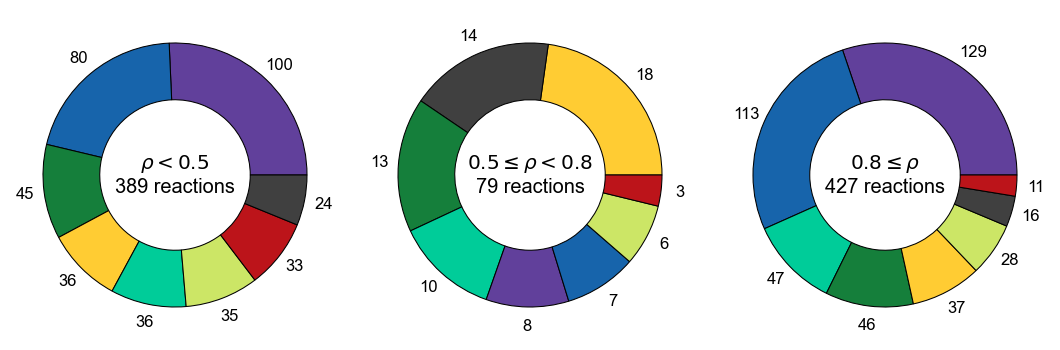

In [29]:
classifications_w_texts = {
    "independent": rf"$\rho  <{abundance_correlated_cutoff}$",
    "correlated": rf"${abundance_correlated_cutoff} \leq \rho < {abundance_dependent_cutoff}$",
    "dependent": rf"${abundance_dependent_cutoff} \leq \rho$",
}
rings = [
    "category",
    # "subsystem"
]
all_rings_fig, all_rings_axes = plt.subplots(
    1,
    len(classifications_w_texts),
    figsize=(ring_figsize * len(classifications_w_texts), ring_figsize),
)
for idx, (classification, ring_center_text) in enumerate(
    classifications_w_texts.items()
):
    df = df_classified_reactions_categories[
        df_classified_reactions_categories["classification"] == classification
    ]
    df = df.loc[:, rings].copy()
    fig_ring = mpl.figure.Figure(figsize=(ring_figsize, ring_figsize))
    ax_ring = fig_ring.add_subplot()
    ax_ring = plot_ring_of_category_counts(
        df,
        ax=ax_ring,
        ring_center_text="\n".join((ring_center_text, f"{len(df)} reactions")),
        cmap_dict_level_0=category_cmap_names,
        **plot_kwargs,
    )
    fig_ring.tight_layout()
    if save_figures:
        fig_ring.savefig(
            group_results_dirpath
            / f"{classification.capitalize()}Reactions_{model_id}.{imagetype}",
            transparent=transparent,
            format=imagetype,
        )
    plot_ring_of_category_counts(
        df,
        ax=all_rings_axes[idx],
        ring_center_text="\n".join((ring_center_text, f"{len(df)} reactions")),
        cmap_dict_level_0=category_cmap_names,
        **plot_kwargs,
    )
all_rings_fig.tight_layout()
if save_figures:
    all_rings_fig.savefig(
        group_results_dirpath / f"AllClassifiedReactions_{model_id}.{imagetype}",
        transparent=transparent,
        format=imagetype,
    )
all_rings_fig;

#### Genes/Proteins

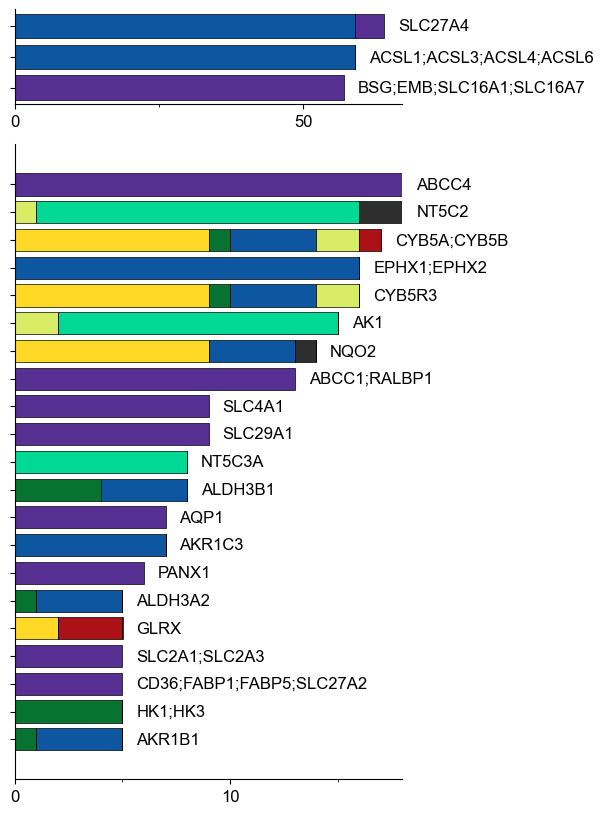

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(5, 10))
plot_kwargs = plot_reaction_counts_kwargs.copy()
classification = "dependent"
df = df_classified_reactions_categories[
    df_classified_reactions_categories["classification"] == classification
].copy()
plot_reaction_counts_for_proteins(
    df,
    ax=ax,
    cutoff_value=5,
    seperator_value=20,
    seperator_scalar=5,
    category_colors=category_cmap_names,
    **plot_kwargs,
)
if save_figures:
    fig.savefig(
        group_results_dirpath
        / f"{classification.capitalize()}ProtRxnCounts_{model_id}.{imagetype}",
        transparent=transparent,
        format=imagetype,
    )

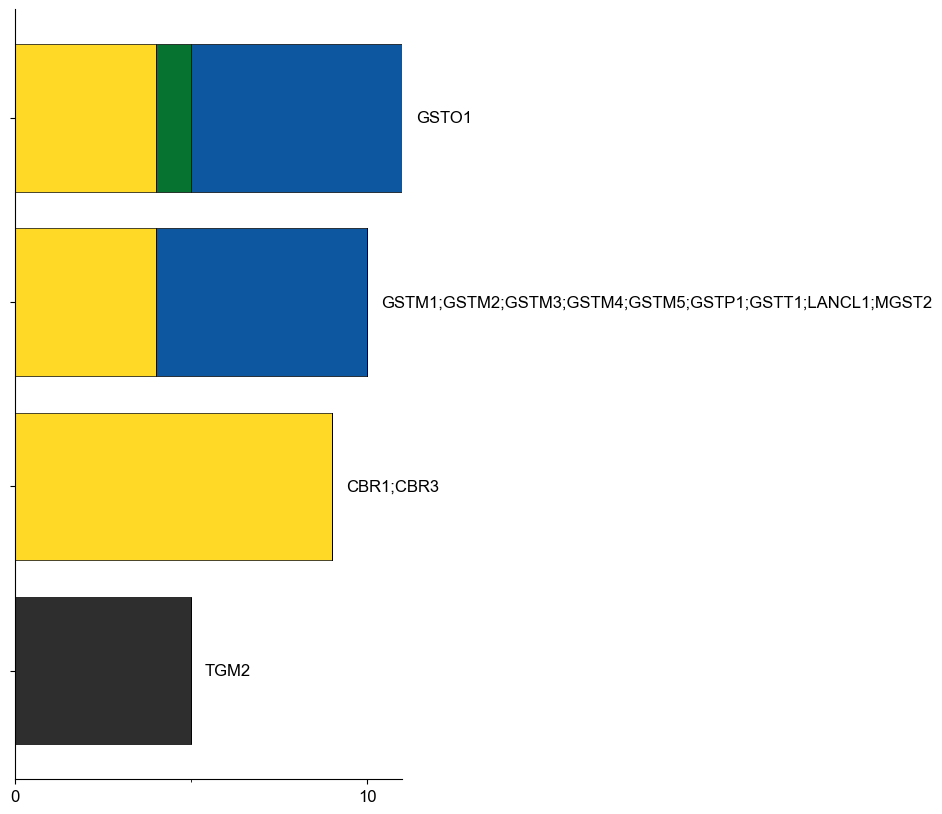

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(5, 10))
plot_kwargs = plot_reaction_counts_kwargs.copy()
classification = "correlated"
df = df_classified_reactions_categories[
    df_classified_reactions_categories["classification"] == classification
].copy()
plot_reaction_counts_for_proteins(
    df,
    ax=ax,
    cutoff_value=5,
    seperator_value=0,
    seperator_scalar=1,
    category_colors=category_cmap_names,
    **plot_kwargs,
)
if save_figures:
    fig.savefig(
        group_results_dirpath
        / f"{classification.capitalize()}ProtRxnCounts_{model_id}.{imagetype}",
        transparent=transparent,
        format=imagetype,
    )

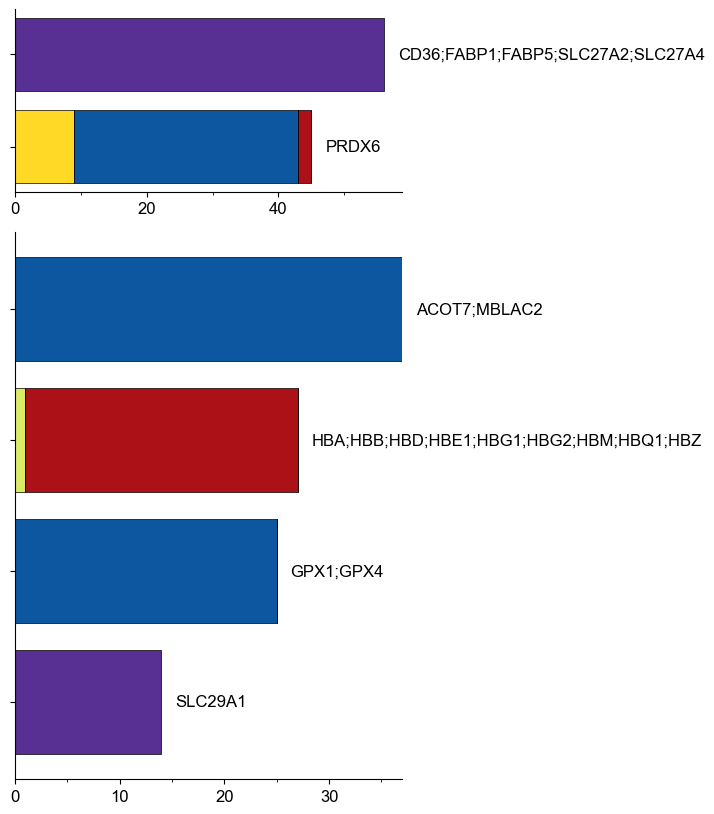

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(5, 10))
plot_kwargs = plot_reaction_counts_kwargs.copy()
classification = "independent"
df = df_classified_reactions_categories[
    df_classified_reactions_categories["classification"] == classification
].copy()
plot_reaction_counts_for_proteins(
    df,
    ax=ax,
    cutoff_value=10,
    seperator_value=40,
    seperator_scalar=2,
    category_colors=category_cmap_names,
    **plot_kwargs,
)
if save_figures:
    fig.savefig(
        group_results_dirpath
        / f"{classification.capitalize()}ProtRxnCounts_{model_id}.{imagetype}",
        transparent=transparent,
        format=imagetype,
    )

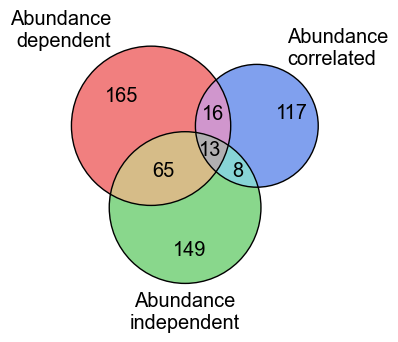

In [33]:
df_venn = df_classified_reactions_categories.copy()
df_venn["genes"] = df_venn["genes"].str.split(";")
df_venn = df_venn[["classification", "genes"]].explode("genes")
df_venn = (
    df_venn[df_venn != ""]
    .groupby(["classification"])
    .agg(lambda x: list(set(x.unique())))
)

fig_venn, ax_venn = plt.subplots(1, 1, figsize=(4, 4))
dep_genes = set(df_venn.loc["dependent"].item())
cor_genes = set(df_venn.loc["correlated"].item())
ind_genes = set(df_venn.loc["independent"].item())
venn = mpl_venn.venn3(
    subsets=[dep_genes, cor_genes, ind_genes],
    set_labels=[
        "Abundance\ndependent",
        "Abundance\ncorrelated",
        "Abundance\nindependent",
    ],
    set_colors=("xkcd:red", "xkcd:blue", "xkcd:green"),
    alpha=0.5,
    ax=ax_venn,
)
circles = mpl_venn.venn3_circles(
    ax=ax_venn,
    subsets=[dep_genes, cor_genes, ind_genes],
    linestyle="-",
    color="black",
    linewidth=1,
)
for text in venn.set_labels:
    text.set_fontsize("x-large")
for text in venn.subset_labels:
    text.set_fontsize("x-large")

fig_venn.tight_layout()
if save_figures:
    fig_venn.savefig(
        group_results_dirpath / f"ProteinIntersections_{model_id}.{imagetype}",
        transparent=transparent,
        format=imagetype,
    )

In [34]:
dep_genes.intersection(cor_genes).intersection(ind_genes)

{'ABCE1',
 'BSG',
 'EMB',
 'LDHA',
 'LDHB',
 'NT5C',
 'PGP',
 'PRDX1',
 'PRDX2',
 'PRDX4',
 'SLC16A1',
 'SLC16A7',
 'SLC4A1'}